In [1]:
from comment_analysis import *
from feature_tools import *
from cleaning_utility import *
import pandas as pd
import importlib


In [ ]:
_, _, comments_en_copy = analyze_comments(df_comments) #this step is very long!
df_comments_sentiment = comments_en_copy.copy()

# as the previous step takes some time to run, the result is saved and can be loaded for further use
df_comments_sentiment.to_pickle("./df_comments_sentiment_final.pkl")

# drop 'neutrality' and 'compound' columns
df_comments_sentiment.drop(columns = ['neutrality', 'compound'], inplace = True)

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Giacomo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df_listings = pd.read_csv('/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/2019-09-14_Amsterdam_listings_detailed.csv', header=0, low_memory = False)
df_neighbourhood = pd.read_csv('/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/NaT_Amsterdam_neighbourhoods.csv')
df_comments = pd.read_csv('/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/2019-09-14_Amsterdam_reviews.csv', header=0)

# drop neighbourhood_group column as it is only filled with NaN
df_neighbourhood = df_neighbourhood.drop(columns = ['neighbourhood_group'])

# transform neighbourhood name into a categorical integer to create a new feature
df_neighbourhood['neighborhood_id'] = df_neighbourhood.index.values + [1]*df_neighbourhood.shape[0]

#############################
df_comments_sentiment = pd.read_pickle("../data/df_comments_sentiment_final.pkl")

#############################

# create a new dataframe for success metrics
df_success_metrics = pd.merge(df_listings[['id', 'review_scores_rating', 'reviews_per_month']],
                              df_comments_sentiment, left_on='id', right_on='listing_id')
# change index to id
df_success_metrics = df_success_metrics.set_index('id')


features_ensemble       = ['id', 'host_since', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                          'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                          'property_type', 'room_type', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
                          'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 
                          'instant_bookable', 'cancellation_policy']
# features are seperated depending on their types to be prepared before being used for ML
date_features           = 'host_since'
bool_features           = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
list_features           = ['host_verifications', 'amenities']
price_features          = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
neighborhood_features   = ['neighbourhood_cleansed']
string_features         = ['property_type', 'cancellation_policy','room_type', 'bed_type']
rate_features           = ['host_response_rate']
replace_nan_features    = ['host_response_rate', 'host_is_superhost', 'host_total_listings_count', 'security_deposit', 'cleaning_fee', 'number_of_amenities']
replace_values          = [0, 0, 0, 0, 0, 0]
# create an instance of the class CleaningUtility()
cu = CleaningUtility()
# FEATURES PREPARATION

# using the class CleaningUtility(), features are prepared to be used 
df_features = df_listings[features_ensemble].copy()
df_features = cu.bool_to_int(df_features, bool_features)
df_features = cu.host_activity_period(df_features, date_features)
df_features = cu.list_to_number_of_services(df_features, list_features)
df_features = cu.format_price(df_features, price_features)
df_features = cu.format_rate(df_features, rate_features)
df_features = cu.replace_nan_by_values(df_features, replace_nan_features, replace_values)

# create a new feature with neighbourhood_id which indicates in which neighborhood of this city the listing is located
df_features = cu.string_to_id(df_features, neighborhood_features[0], df_neighbourhood.neighbourhood, df_neighbourhood.neighborhood_id)

# convert string_featutes to one-hot labels (-> will increase the number of columns)
df_features = cu.convert_to_one_hot_label(df_features, string_features)

# computes the price per person
df_features = cu.prices_per_person(df_features, price_features[0:-1], 'guests_included')

##############################################################
## now that all the data are numeric, convert all to float64 #
##############################################################
cols           = df_features.columns
df_features[cols] = df_features[cols].apply(pd.to_numeric, errors = 'raise')

##############################################################
############# keep only rows with non-nan values #############
##############################################################
tmp      = df_features.shape[0]
df_features = cu.select_numeric_column_only(df_features)
df_features = df_features.dropna()

##############################################################
##################### print cleaning info ####################
##############################################################
print('\nNumber of rows    before data set cleaning:       %.0f'%(df_listings.shape[0]))
print(  'Number of rows    after data set cleaning:        %.0f'%(tmp))
print(  'Number of rows    after removal of rows with nan: %.0f'%(df_features.shape[0]))
print(  'Number of columns before data set cleaning:       %.0f'%(df_listings.shape[1]))
print(  'Number of columns initially selected:             %.0f'%len(features_ensemble))
print(  'Number of columns after data set cleaning:        %.0f'%(df_features.shape[1]))

display(df_features.describe())
df_features.head()

# merge to have metrics and features in the same dataFrame
df_features_w_metrics = pd.merge(df_success_metrics, df_features, left_on = 'id', right_on = 'id')

# set 'id' as the index of the dataFrame
df_features_w_metrics = df_features_w_metrics.set_index('id')
df_features_w_metrics.head()

# for all these step random_seed is set to 1
random_seed = 1

In [ ]:
def perform_rf(metric, df_features_w_metrics, success_metrics_features, tune = False):
    '''
    takes the DataFrame containing features and metrics as argument, removes all metrics except one
    which becomes then the 'label' and finally performs the random forest on these datas
    '''
    df = df_features_w_metrics.copy()
    m = success_metrics_features.copy()
    m.remove(metric)
    df = df.drop(columns = m)
    print('Random forest of features for the metric: ' + metric)
    f = FeaturesTools(df, metric, random_seed = random_seed)
    norm_feat = f.normalize_features()
    f = FeaturesTools(norm_feat, metric, random_seed = random_seed)
    imp, rf = f.randomForestAnalysis(plotResults = True, tuneModelParameters = tune)
    return imp, rf, f

In [ ]:
# perform random forest for each metric
metric1 = 'review_scores_rating'
imp1, rf1, f1 = perform_rf(metric1, df_features_w_metrics, success_metrics_features)

In [2]:
import os
import time
import pydot
import folium
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from folium.plugins import MiniMap
from IPython.core.display import display
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from treeinterpreter import treeinterpreter as ti, utils
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [415]:
import cleaning_utility
import feature_tools

In [418]:
importlib.reload(feature_tools)
importlib.reload(cleaning_utility)

random_seed = 1
input_csv_file      = '/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/2019-09-14_Amsterdam_listings_detailed.csv'
neighbourhoods_file = '/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/NaT_Amsterdam_neighbourhoods.csv'
mask_file           = '/Volumes/Disk2/Courses MA3/MA3 - ADA//airbnb_ada_project/img/house_mask.png'


df       = pd.read_csv(input_csv_file, low_memory = False);
neigh_df = pd.read_csv(neighbourhoods_file)

neigh_df['neighborhood_id'] = neigh_df.index.values + [1]*neigh_df.shape[0]

#  review_scores_rating is calculated as weighted sum of other scores
selected_features       = ['host_since', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                          'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                          'property_type', 'room_type', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
                          'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 
                          'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                          'instant_bookable', 'cancellation_policy']

rating_features         = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
date_features           = 'host_since'
bool_features           = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
list_features           = ['host_verifications', 'amenities']
price_features          = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
neighborhood_features   = ['neighbourhood_cleansed']
string_features         = ['property_type', 'cancellation_policy','room_type', 'bed_type']
rate_features           = ['host_response_rate']
replace_nan_features    = ['host_response_rate', 'host_is_superhost', 'host_total_listings_count', 'security_deposit', 
                           'number_of_amenities', 'cleaning_fee']
replace_values          = [0, 0, 1, 0, 0, 0]

cu       = cleaning_utility.CleaningUtility()
features = df[selected_features].copy()
features = cu.bool_to_int(features, bool_features)
features = cu.host_activity_period(features, date_features)
features = cu.list_to_number_of_services(features, list_features)
features = cu.format_price(features, price_features)
features = cu.format_rate(features, rate_features)
features = cu.replace_nan_by_values(features, replace_nan_features, replace_values)
# TODO: better to transform neigh into one-hot label instead as on ID to find the best quartier?
features = cu.string_to_id(features, neighborhood_features[0], neigh_df.neighbourhood, neigh_df.neighborhood_id)
# TODO: appropriate also for property_type or should create macro groups such as house, ... Same for room_type and bed_type
features = cu.convert_to_one_hot_label(features, string_features)
features = cu.prices_per_person(features, price_features[0:-1], 'guests_included')


# list of IDs
# print('> The unique properties in the dataset are:')
# reference_strings = df['property_type'].unique()
# reference_IDs     = [0]
# print(reference_strings)

##############################################################
## now that all the data are numeric, convert all to float64 #
##############################################################
cols           = features.columns
features[cols] = features[cols].apply(pd.to_numeric, errors = 'raise')

##############################################################
############# keep only rows with non-nan values #############
##############################################################
tmp      = features.shape[0]
features = cu.select_numeric_column_only(features)
features = features.dropna()

##############################################################
##################### print cleaning info ####################
##############################################################
print('\nNumber of rows    before data set cleaning:       %.0f'%(df.shape[0]))
print(  'Number of rows    after data set cleaning:        %.0f'%(tmp))
print(  'Number of rows    after removal of rows with nan: %.0f'%(features.shape[0]))
print(  'Number of columns before data set cleaning:       %.0f'%(df.shape[1]))
print(  'Number of columns initially selected:             %.0f'%len(selected_features))
print(  'Number of columns after data set cleaning:        %.0f'%(features.shape[1]))

display(features.describe())
display(features.head())

> Running bool_to_int...
> Running host_activity_period...
All activities periods extracted but some nan are present

> Running list_to_number_of_services...
> Running format_price...
> Running format_rate...
> Running replace_nan_by_values...
> Running string_to_id...
> Running convert_to_one_hot_label...
> Running prices_per_person...
> Running select_numeric_column_only...

Number of rows    before data set cleaning:       20244
Number of rows    after data set cleaning:        20244
Number of rows    after removal of rows with nan: 17652
Number of columns before data set cleaning:       106
Number of columns initially selected:             29
Number of columns after data set cleaning:        75


,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,price,security_deposit,cleaning_fee,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,price_per_person,security_deposit_per_person,cleaning_fee_per_person
count,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,...,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000
mean,56.175731,56.333730,0.173125,5.043904,0.999603,0.408679,11.391967,154.677770,159.321833,33.228813,...,0.192783,0.002549,0.000736,0.000227,0.001983,0.006118,0.990936,121.526966,120.385073,25.506871
std,23.258191,47.783352,0.378366,27.555681,0.019910,0.491604,6.177391,140.912024,322.756868,25.515365,...,0.394495,0.050427,0.027129,0.015052,0.044485,0.077982,0.094776,118.944494,270.232106,21.673675
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,99.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,69.500000,0.000000,10.000000
50%,58.000000,90.000000,0.000000,1.000000,1.000000,0.000000,9.000000,130.000000,91.500000,35.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,100.000000,37.500000,22.500000
75%,74.000000,100.000000,0.000000,1.000000,1.000000,1.000000,18.000000,180.000000,250.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,150.000000,150.000000,39.000000
max,133.000000,100.000000,1.000000,932.000000,1.000000,1.000000,22.000000,8915.000000,4489.000000,500.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8915.000000,4485.000000,500.000000


,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,price,security_deposit,cleaning_fee,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,price_per_person,security_deposit_per_person,cleaning_fee_per_person
0,133.0,100,1.0,1.0,1.0,0.0,15,59.0,200.0,60.0,...,1,0,0,0,0,0,1,59.0,200.0,60.0
1,118.0,100,0.0,2.0,1.0,0.0,5,80.0,0.0,0.0,...,1,0,0,0,0,0,1,40.0,0.0,0.0
2,119.0,100,0.0,2.0,1.0,0.0,6,125.0,300.0,40.0,...,0,0,0,0,0,0,1,62.5,150.0,20.0
3,115.0,100,1.0,1.0,1.0,1.0,6,155.0,0.0,0.0,...,1,0,0,0,0,0,1,155.0,0.0,0.0
4,113.0,100,1.0,3.0,1.0,1.0,6,75.0,0.0,0.0,...,1,0,0,0,0,0,1,75.0,0.0,0.0


In [5]:
import importlib
import feature_tools

In [168]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.1.


> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.080104

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+-----------+
|                       |  review_scores_rating  |    AVG    |
|-----------------------+------------------------+-----------|
|       R^2 error       |       0.0989311        | 0.0989311 |
|       MSE error       |        35.5741         |  35.5741  |
|       MAE error       |        3.95373         |  3.95373  |
| Median Absolute error |          2.83          |   2.83    |
+-----------------------+------------------------+-----------+


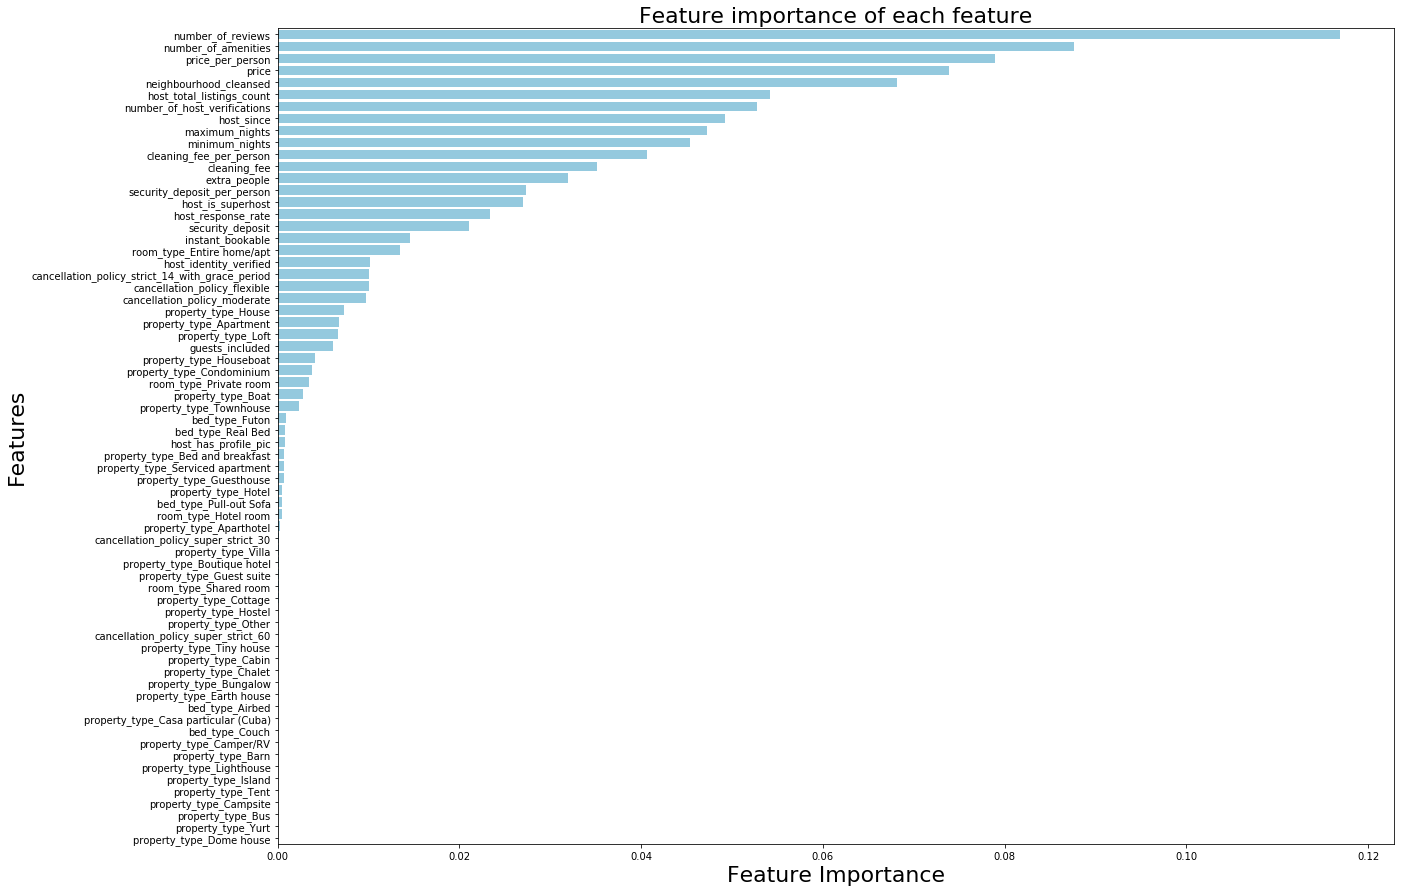

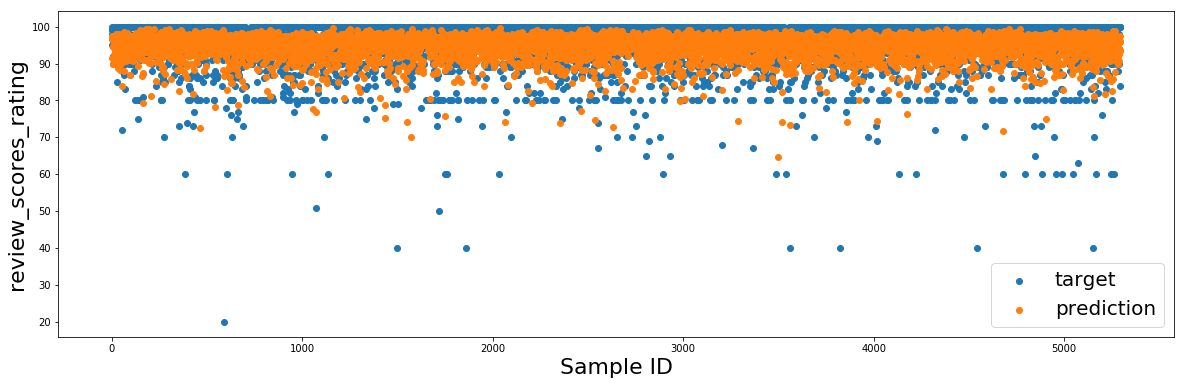

In [30]:
# TRY SINGLE LABEL RANDOMFOREST
importlib.reload(feature_tools)


f1 = feature_tools.FeaturesTools(df = features[features.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
#imp1, rf = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = True)
# df_importance, df_err, rf, cv_rsults, best_params_ = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = True)
df_importance, df_err, rf = f1.randomForestAnalysis(plotResults = [True, False, True, False], tuneModelParameters = False)

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.060995

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+--------------------------+-----------+
|                       |  review_scores_rating  |  review_scores_accuracy  |    AVG    |
|-----------------------+------------------------+--------------------------+-----------|
|       R^2 error       |        0.100831        |        0.0881723         | 0.0945014 |
|       MSE error       |        35.4991         |         0.418583         |  17.9589  |
|       MAE error       |        3.95382         |         0.421354         |  2.18759  |
| Median Absolute error |          2.82          |           0.31           |   1.565   |
+-----------------------+------------------------+--------------------------+-----------+


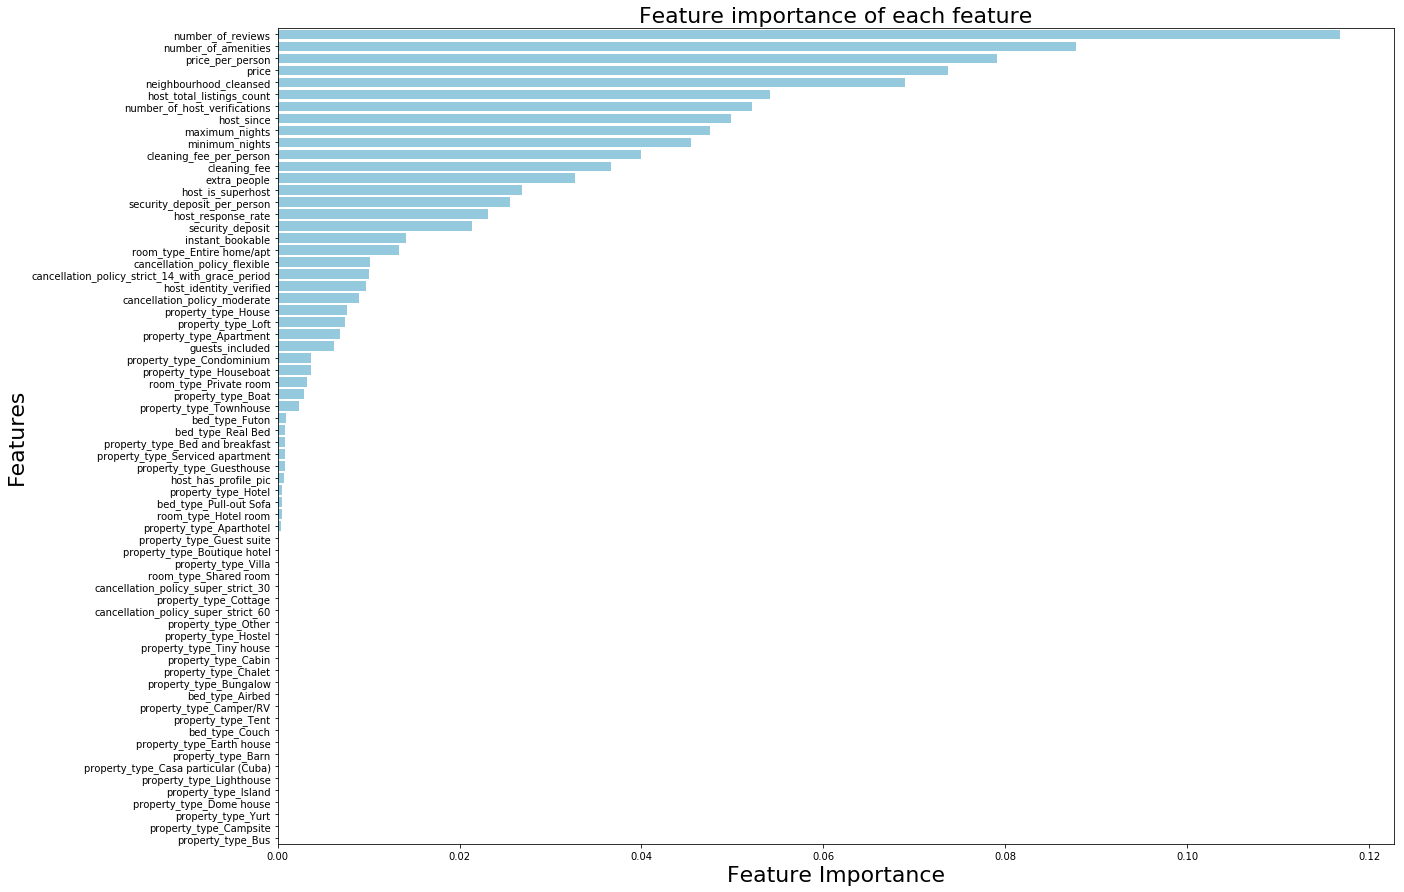

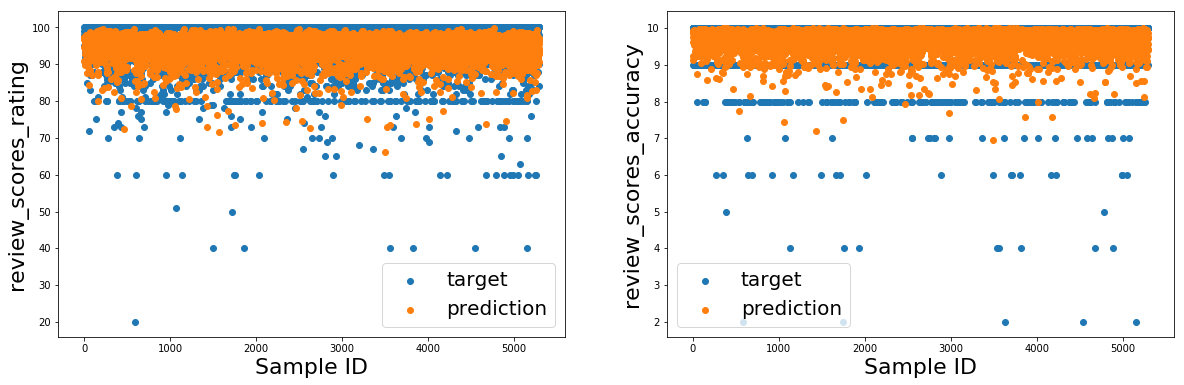

In [29]:
# TRY MULTILABEL RANDOMFOREST
importlib.reload(feature_tools)


f1 = feature_tools.FeaturesTools(df = features[features.columns.difference(rating_features[2:])],
                                 label_name = rating_features[0:2], random_seed = random_seed)
#imp1, rf = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = True)
# df_importance, df_err, rf, cv_rsults, best_params_ = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = True)
df_importance, df_err, rf = f1.randomForestAnalysis(plotResults = [True, False, True, False], tuneModelParameters = False)


In [217]:
prediction, bias, contributions = f1.treeInterpreter(rf)

> Running treeInterpreter...

SORRY, tree interpretation not possible for a multilabel model using treeInterpreter method from FeaturesTools class !!!



> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 Training Score:     0.701313
R^2 OOB Score:          0.095233

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+-------------+
|                       |  review_scores_rating  |     AVG     |
|-----------------------+------------------------+-------------|
|       R^2 error       |        0.109826        |  0.109826   |
|       MSE error       |      2.19442e-07       | 2.19442e-07 |
|       MAE error       |      0.000311055       | 0.000311055 |
| Median Absolute error |      0.000223249       | 0.000223249 |
+-----------------------+------------------------+-------------+


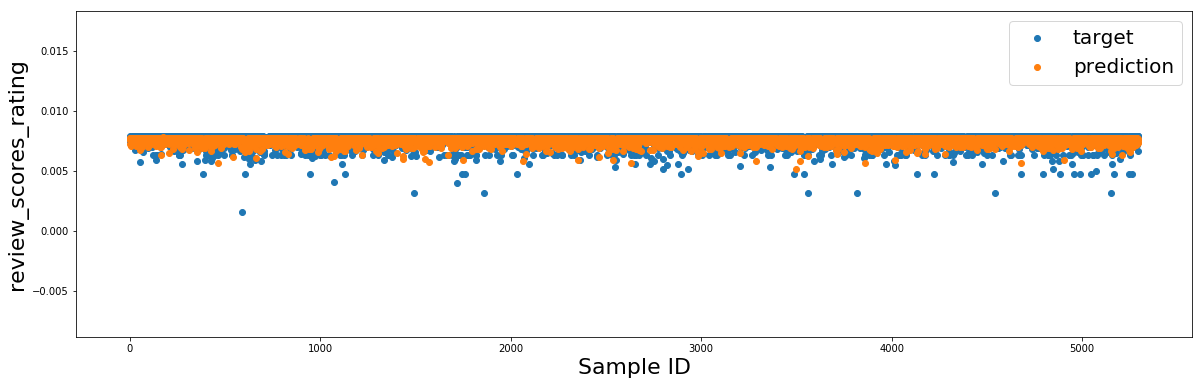

In [23]:
# TRY NORMALIZATION
importlib.reload(feature_tools)

f1 = feature_tools.FeaturesTools(df = features[features.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
norm_feat = f1.preprocess_features(preprocessing_type = 'normalize')

f1 = feature_tools.FeaturesTools(df = norm_feat[norm_feat.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
df_importance, df_err, rf = f1.randomForestAnalysis(plotResults = [False, False, True, False], tuneModelParameters = False)

> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 Training Score:     0.874534
R^2 OOB Score:          0.077412

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+-----------+
|                       |  review_scores_rating  |    AVG    |
|-----------------------+------------------------+-----------|
|       R^2 error       |       0.0944575        | 0.0944575 |
|       MSE error       |        0.825104        | 0.825104  |
|       MAE error       |        0.601562        | 0.601562  |
| Median Absolute error |        0.428411        | 0.428411  |
+-----------------------+------------------------+-----------+


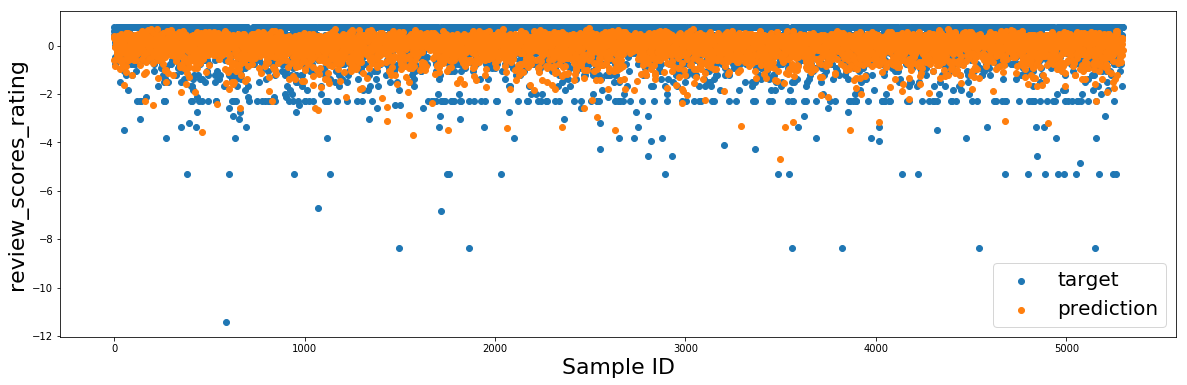

In [24]:
# TRY STANDARDIZATION
importlib.reload(feature_tools)

f1 = feature_tools.FeaturesTools(df = features[features.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
stand_feat = f1.preprocess_features(preprocessing_type = 'standardize')

f1 = feature_tools.FeaturesTools(df = stand_feat[stand_feat.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
df_importance, df_err, rf = f1.randomForestAnalysis(plotResults = [False, False, True, False], tuneModelParameters = False)

> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 Training Score:     0.874656
R^2 OOB Score:          0.078683

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+-----------+
|                       |  review_scores_rating  |    AVG    |
|-----------------------+------------------------+-----------|
|       R^2 error       |       0.0970308        | 0.0970308 |
|       MSE error       |        0.727534        | 0.727534  |
|       MAE error       |        0.565296        | 0.565296  |
| Median Absolute error |          0.4           |    0.4    |
+-----------------------+------------------------+-----------+


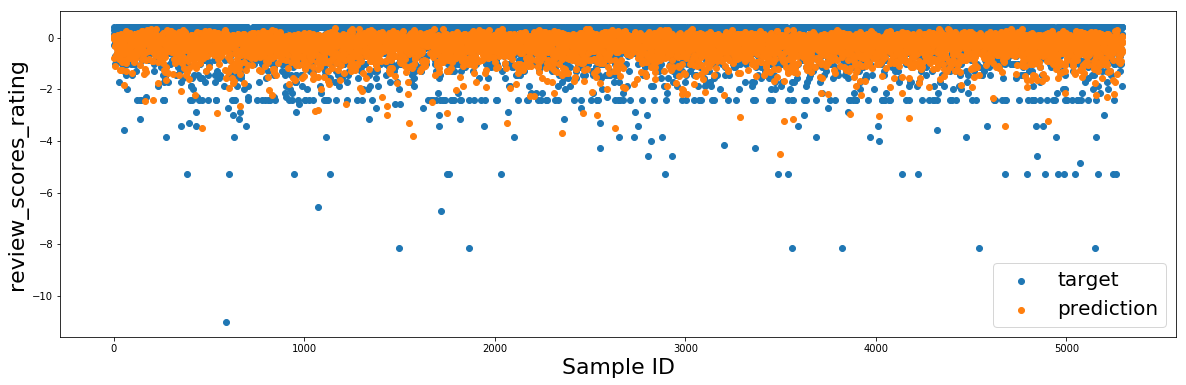

In [25]:
# TRY ROBUST STANDARDIZATION (INSENSIBLE TO OUTLIERS)
importlib.reload(feature_tools)

f1 = feature_tools.FeaturesTools(df = features[features.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
stand_robust_feat = f1.preprocess_features(preprocessing_type = 'standardize_robust')

f1 = feature_tools.FeaturesTools(df = stand_robust_feat[stand_robust_feat.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
df_importance, df_err, rf = f1.randomForestAnalysis(plotResults = [False, False, True, False], tuneModelParameters = False)

> Running normalize_features...

> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.080482

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+------------+
|                       |  review_scores_rating  |    AVG     |
|-----------------------+------------------------+------------|
|       R^2 error       |       0.0990588        | 0.0990588  |
|       MSE error       |       0.00555767       | 0.00555767 |
|       MAE error       |       0.0495029        | 0.0495029  |
| Median Absolute error |         0.035          |   0.035    |
+-----------------------+------------------------+------------+
TEST
False


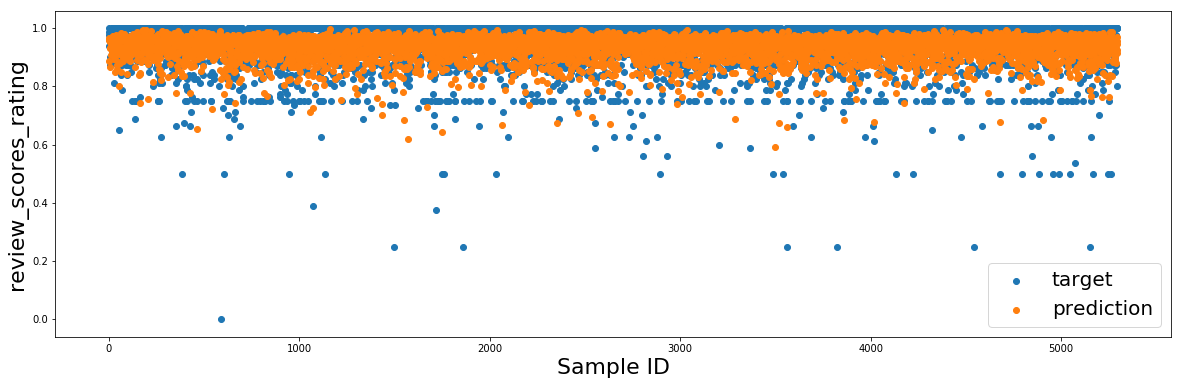

In [45]:
# TRY SCALING TO [0, 1] RANGE (INSENSIBLE TO OUTLIERS)
importlib.reload(feature_tools)

f1 = feature_tools.FeaturesTools(df = features[features.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
scaled_unit_feat = f1.preprocess_features(preprocessing_type = 'scale_unit')

f1 = feature_tools.FeaturesTools(df = scaled_unit_feat[scaled_unit_feat.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
df_importance, df_err, rf = f1.randomForestAnalysis(plotResults = [False, False, True, False], tuneModelParameters = False)

# TRY sankey plot with colors

In [ ]:
# create an example of dataframe for the connections

importlib.reload(feature_tools)

df_contributions = pd.DataFrame()
neigh_ID   = 5
neigh_name = neigh_df[neigh_df['neighborhood_id'] == neigh_ID].neighbourhood.values[0]

idx = 0
for i in rating_features:
    # at each time use only one of the rating_features, exclude the others
    discard_feat = list(filter(lambda x : x != i, rating_features))
    feat_tmp = features[features.columns.difference(discard_feat)]
    
    f_i = feature_tools.FeaturesTools(df = feat_tmp, label_name = i, random_seed = random_seed)
    f_i.randomForestAnalysis(plotResults = [False, False, False, False], tuneModelParameters = False)
    
    tmp = feat_tmp.loc[features['neighbourhood_cleansed'] == neigh_ID].drop(i, axis = 1)
    prediction, bias, contributions = f_i.treeInterpreter(rf, tmp)
    mean_features_contribution = np.mean(contributions, axis=0)

    df_contributions_tmp = pd.DataFrame({'feature_source':tmp.columns,
                                         'feature_target':[i]*len(tmp.columns),
                                         'contribution':mean_features_contribution})
    
    df_contributions = pd.concat([df_contributions, df_contributions_tmp])
    idx += 1

    
labels = [x for x in features.columns.values if x not in rating_features] + rating_features
ids    = np.arange(0, len(labels))
replace_dict = {}
for ref_s, ref_id in zip(labels, ids):
    replace_dict.update({ref_s:ref_id})
df_contributions['source'] = df_contributions['feature_source'].replace(replace_dict)
df_contributions['target'] = df_contributions['feature_target'].replace(replace_dict)
labels = labels + [np.nan]*(df_contributions.shape[0]-len(labels))
df_contributions['labels'] = labels


> Running interactive_sankey...



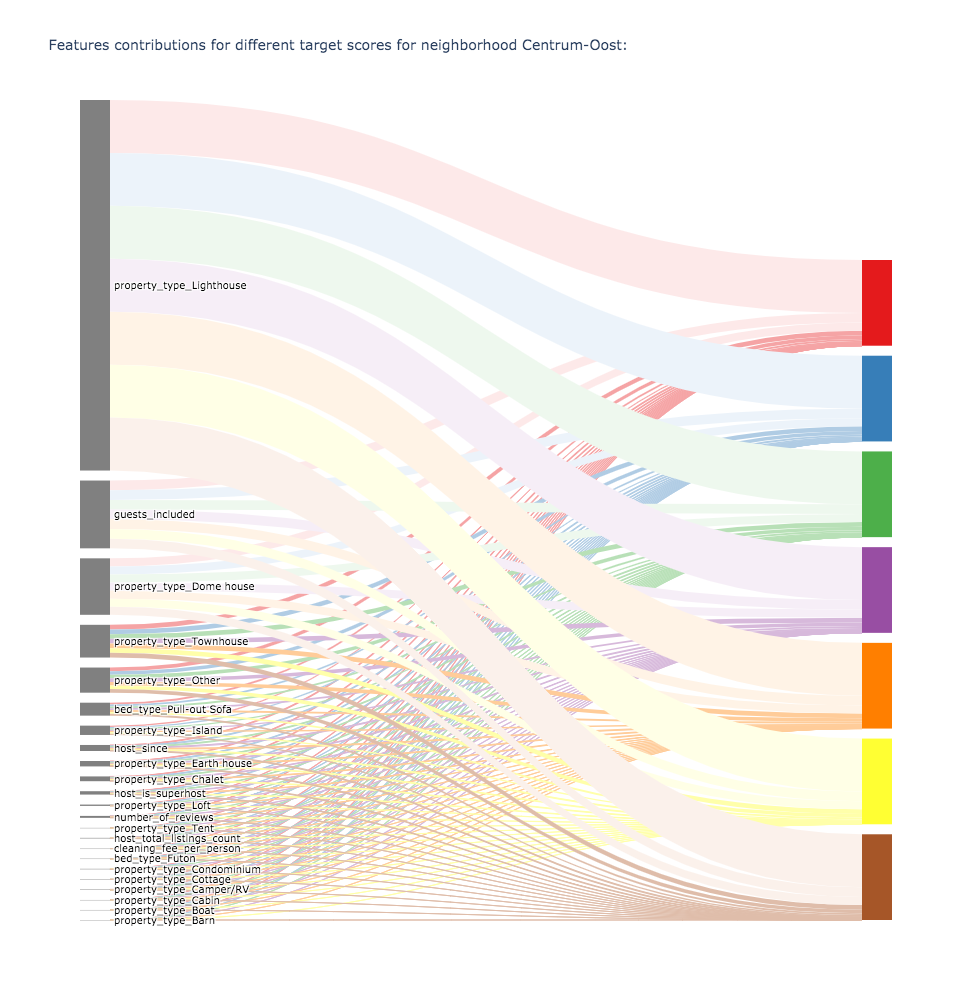

In [306]:
importlib.reload(feature_tools)


f2 = feature_tools.FeaturesTools()

nb_colors = len(df_contributions.target.unique())
colors = sns.color_palette('Set1', nb_colors)

# add souces/targets boxs colors
color_nodes = ['#808080'] * len([x for x in features.columns.values if x not in rating_features]) + colors.as_hex()
color_nodes = color_nodes + [np.nan]*(df_contributions.shape[0]-len(color_nodes))
df_contributions['color'] = color_nodes

# add trajectories colors
colors_trajectories = []
for target, color in zip(df_contributions.target.unique(), colors):
    df_tmp = df_contributions[df_contributions['target'] == target]
    target_color_scale   = sns.light_palette(color, 4, reverse = True)
    #print(target_color_scale)
    # convert color palette to string format style: rgba(253, 253, 253, 0.5)
    tmp = []
    for jj in target_color_scale:
        tmp = np.append(tmp, 'rgb' + str(tuple(int(np.ceil(i * 255)) for i in jj[0:3]) + (jj[3], )))
        #tmp = np.append(tmp, 'rgba' + str(jj))
    target_color_scale = tmp
    target_mapped_colors = f2.map_to_color(target_color_scale, df_tmp.contribution)
    colors_trajectories  = np.append(colors_trajectories, target_mapped_colors)
df_contributions['linkColor'] = colors_trajectories


# do sankey plot
f2.interactive_sankey(df_contributions, 'Features contributions for different target scores for neighborhood ' + neigh_name + ':')    

In [389]:
15*12

180

In [390]:
12*14+10+6

184

In [399]:
current_month = 10
start_year = 2003
start_month = 3

In [400]:
current_month + 12*(2019-1-start_year) + (12 - start_month)

199

In [75]:
df_test = pd.DataFrame(test)
a = df_test.transpose()
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_fit_time,40.3307,13.898,204.922,27.932,51.9647,158.881,9.21831,36.7014,19.3083,10.2381,34.859,135.616,45.9471,23.8695,25.4046,21.7989,136.712,108.971,165.195,4.29131
std_fit_time,0.421011,0.0936369,4.10039,0.449808,0.540758,2.04731,0.374749,1.24295,0.565833,0.817655,0.346699,2.80734,1.79566,0.2385,0.330525,0.884806,2.82846,1.58789,14.2384,0.117637
mean_score_time,2.51364,0.220545,2.40519,1.56793,0.571238,2.12634,0.133969,2.20177,1.14948,0.200406,2.01337,1.73345,2.79456,1.60164,1.73844,1.59645,1.75641,1.40788,1.52298,0.280606
std_score_time,0.114953,0.00172663,0.0413686,0.0290814,0.058816,0.324243,0.018798,0.0633338,0.0376173,0.0314716,0.234866,0.180203,0.270485,0.152248,0.298934,0.31565,0.298367,0.0180131,0.0689931,0.0163586
param_warm_start,True,True,False,False,True,True,True,True,False,False,True,True,True,False,False,True,False,False,False,True
param_n_estimators,1800,1300,1800,1400,1200,1800,100,2000,900,1000,1300,1200,1400,1000,1000,900,1500,1100,2100,200
param_min_samples_split,10,10,5,2,2,10,2,10,2,2,5,5,2,10,5,2,5,10,5,5
param_min_samples_leaf,1,2,1,4,2,4,4,2,2,2,1,2,1,1,1,2,4,1,1,2
param_max_features,sqrt,auto,auto,sqrt,auto,auto,auto,sqrt,sqrt,auto,sqrt,auto,sqrt,sqrt,sqrt,sqrt,auto,auto,auto,sqrt
param_max_depth,99,1,93,35,6,82,58,18,35,1,29,58,82,111,24,None,70,41,41,93


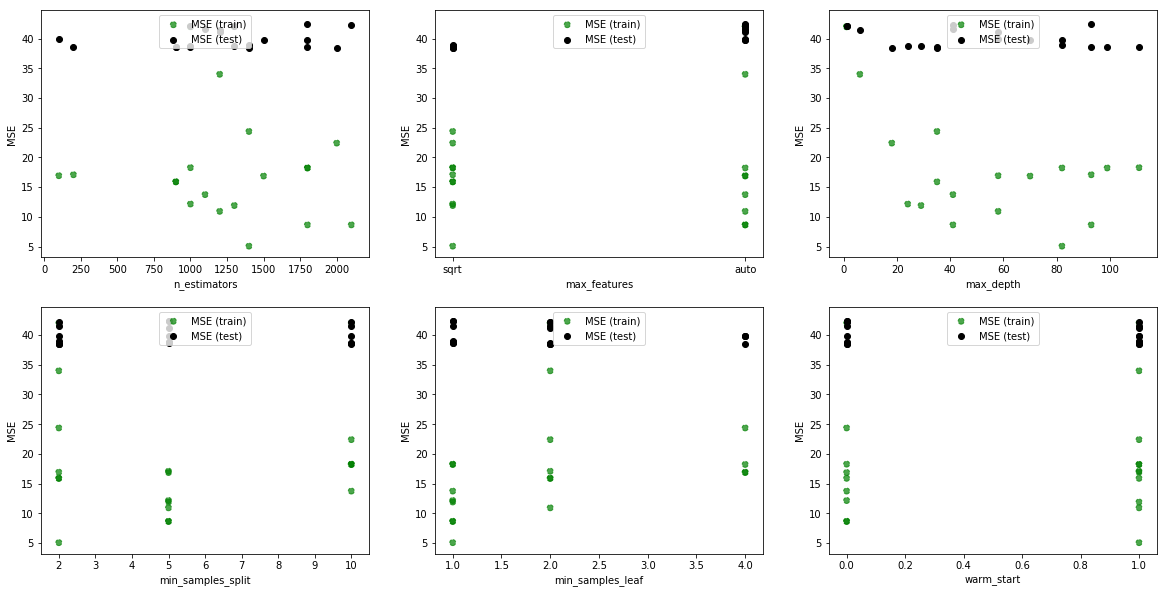

In [93]:
params = ['n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'warm_start']

fig, ax = plt.subplots(2, 3, figsize = (20, 10))

y_train_mse = []
y_train_std = []
y_test_mse = []
y_test_std = []
best_train_idx = 1000
best_test_idx = 1000

idx = 0
for row in ax:
    for col in row:
        x_values = []

        for _, row in df_test.iterrows():

            x_values = np.append(x_values, row['params'][params[idx]])
            if idx == 0:
                y_train_mse = np.append(y_train_mse, row['mean_train_Accuracy'])
                y_train_std = np.append(y_train_std, row['std_train_Accuracy'])
                y_test_mse = np.append(y_test_mse, row['mean_test_Accuracy'])
                y_test_std = np.append(y_test_std, row['std_test_Accuracy'])
                #best_train_idx = np.argmin(y_train_mse)
                #best_test_idx = np.argmin(y_test_acc)

        col.scatter(x_values, y_train_mse, linestyle = '--', color = 'g', alpha = 0.7, label = 'MSE (train)')
        col.scatter(x_values, y_test_mse, linestyle = '-', color = 'k', label = 'MSE (test)')
        #col.fill_between(x_values, y_train_mse - y_train_std, y_train_mse + y_train_std, alpha = 0.1, color = 'g')
        #col.fill_between(x_values, y_test_mse - y_test_std, y_test_mse + y_test_std, alpha = 0.1, color = 'k')
        #col.plot([x_values[best_train_idx], ] * 2, [0, y_train_mse[best_train_idx]], linestyle='-.', color = 'g')
        #col.annotate("%0.2f" % y_train_mse[best_train_idx], (x_values[best_train_idx], y_train_mse[best_train_idx] + 0.5))
        #col.plot([x_values[best_test_idx], ] * 2, [0, y_test_mse[best_test_idx]], linestyle='-.', color = 'k', marker = 'x')
        #col.annotate("%0.2f" % y_test_mse[best_test_idx], (x_values[best_test_idx], y_test_mse[best_test_idx] + 0.5))
        col.set_xlabel(params[idx])
        col.set_ylabel('MSE')
        col.legend(loc = 'upper center')
        
        idx += 1
            
        

In [34]:
df_test.params[0]['n_estimators']

1800

## LEARN FROM THE INTERNATIONAL HOSTS:
If an host has multiple listings, maybe it is because it has a great success and because he knows how to do it. Check what determines the airbnb success in this case.

In [308]:
# get all the listings_detailed.cvs files in the data_location folder

data_location = '/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet'
all_files = os.listdir(data_location)
listings_detailed = [i for i in all_files if 'listings_detailed.csv' in i]

# open all listings_detailed.csv files iteratively. For each file keep:
# the city and the average latitude, longitude
# the host ids
# the host names
# the host number of listings in a city
# those info are stored in df_world

df_world = pd.DataFrame()

idx_advancment = 0
for file in listings_detailed:
    idx_advancment += 1
    city_name = file.split('_')[1]
    print('> Analyzing city ' + str(int(idx_advancment)) + '/' + str(int(len(listings_detailed))) + ' : ' + city_name + '..................', end = '\r')
    tmp = pd.read_csv(data_location + '/' + file, low_memory = False)
    city_latitude = tmp.latitude.mean()
    city_longitude = tmp.longitude.mean()
    tmp['number_listings_by_host'] = tmp.groupby('host_id')['host_id'].transform('size')
    tmp = tmp.sort_values(by = 'number_listings_by_host', ascending = False)
    tmp = tmp.groupby(['host_id', 'host_name']).size().sort_values(ascending = False).to_frame().reset_index()
    tmp.columns = ['host_id', 'host_name', 'nb_listings_city']
    tmp['city'] = city_name
    tmp['city_avg_latitude'] = city_latitude
    tmp['city_avg_longitude'] = city_longitude
    
    df_world = pd.concat([df_world, tmp])
print('\n')

> Analyzing city 101/101 : Vancouver..............................



In [309]:
df_world.head()

,host_id,host_name,nb_listings_city,city,city_avg_latitude,city_avg_longitude
0,19293722,Pauline Et Elliot,84,Brussels,50.838026,4.362902
1,19427428,Sweet Inn,69,Brussels,50.838026,4.362902
2,2792958,Alex,66,Brussels,50.838026,4.362902
3,5056483,Bettina,62,Brussels,50.838026,4.362902
4,23082521,Serenia,52,Brussels,50.838026,4.362902


Now we can extract for example a list of hosts names and ids (use both to avoid duplicates) that have for example more than one listing or that are active in more than one city. As example, hosts active in more than one city are extracted here.

,host_id,host_name,nb_listings_city,city,city_avg_latitude,city_avg_longitude,host_nb_city_presence,nb_listings_world
221,213326446,Carina E-Domizil,4,Berlin,52.509852,13.405645,19,90
3192,213326446,Carina E-Domizil,1,Porto,41.154023,-8.615822,19,90
938,213326446,Carina E-Domizil,1,Bergamo,45.751890,9.773377,19,90
1283,213326446,Carina E-Domizil,2,Venice,45.445772,12.318404,19,90
1284,213326446,Carina E-Domizil,4,South Aegean,36.921193,25.738625,19,90


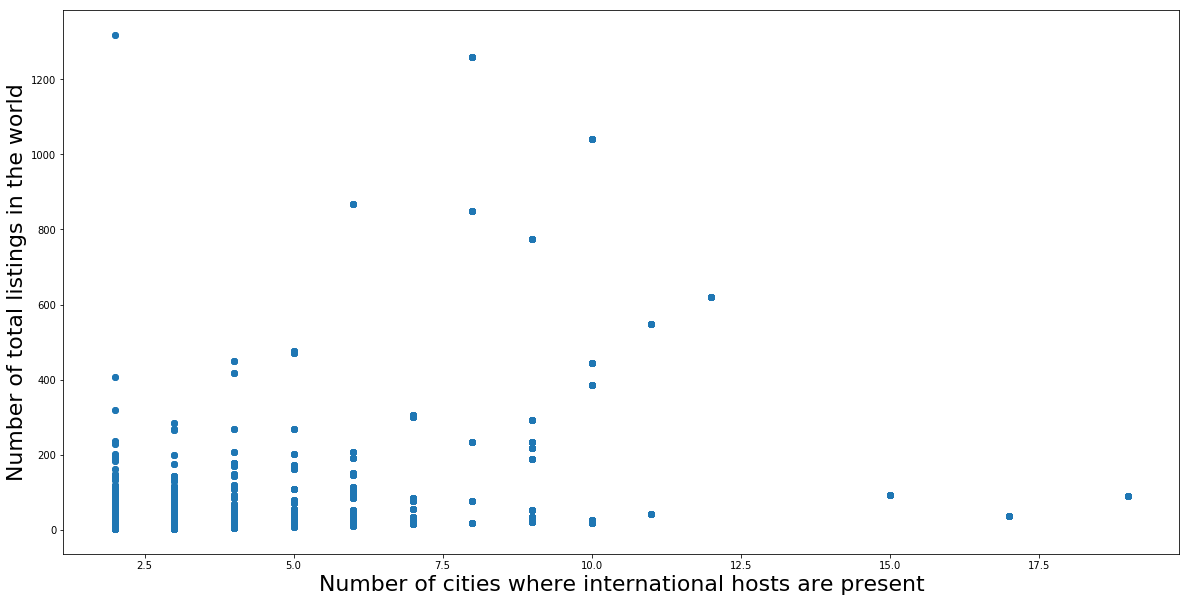

In [320]:
# always use double control host_id AND host_name to be sure to avoid duplicated names [very probables in the whole world !!!]

df_multiple = df_world.copy()
df_multiple['host_nb_city_presence'] = df_multiple.groupby(['host_id', 'host_name'])['city'].transform('size')
df_multiple['nb_listings_world'] = df_multiple.groupby(['host_id', 'host_name'])['nb_listings_city'].transform('sum')
df_multiple = df_multiple[df_multiple['host_nb_city_presence'] > 1].sort_values(by = 'host_nb_city_presence', ascending = False)

display(df_multiple.head())

plt.scatter(df_multiple.host_nb_city_presence, df_multiple.nb_listings_world)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.xlabel('Number of cities where international hosts are present', size = 22)
plt.ylabel('Number of total listings in the world', size = 22)
plt.tick_params(labelsize = 10)
plt.show()

In [321]:
# aggregate df_multiple
df_multiple = df_multiple.groupby(['host_id', 'host_name']).aggregate(lambda x: x.unique().tolist()).reset_index()

display(df_multiple.head())

,host_id,host_name,nb_listings_city,city,city_avg_latitude,city_avg_longitude,host_nb_city_presence,nb_listings_world
0,1618,Elaine,[2],"[Portland, Denver]","[45.52773592880963, 39.74040608998061]","[-122.65006185761978, -104.97485755270577]",[2],[4]
1,2616,Horacio,[1],"[Buenos Aires, Rio de Janeiro]","[-34.59261230599549, -22.965061250546096]","[-58.41623085235179, -43.25448484226134]",[2],[2]
2,3020,Davide,[1],"[Rome, Sicily]","[41.89262049435365, 37.61664014081242]","[12.481527882073575, 14.158457566905163]",[2],[2]
3,8435,Jef Karchin,"[1, 2]","[Los Angeles, San Diego]","[34.05270295385418, 32.76811059307942]","[-118.32398012096922, -117.18003625793321]",[2],[3]
4,9187,Mai,"[6, 1]","[Vancouver, Hawaii]","[49.26041403335504, 20.868094796605806]","[-123.11135420336828, -157.11046272983015]",[2],[7]


Now that we have the list, we can go in all the datasets and extract the rows of all those hosts. Then we run the ML model again. 
NOTE: this could be done better. In fact, we don't have to open all the cities datasets if we already know in which cities are located those hosts: better to open only the corresponding cities .csv files !

--> Pseudocode:

for file in listings_detailed:

    for _, row in df_multiple.iterrows():

        for city in row.city:
    
            if city corresponds to file, open it. Otherwise skip. (!!! Must control lowercase/uppercase. An idea would be to do a case-insensitive comparison)

In [324]:
df_international_hosts = pd.DataFrame()

idx_advancment = 0
t0 = time.time()
for file in listings_detailed:
    idx_advancment += 1
    city_name = file.split('_')[1]
    print('> Analyzing city ' + str(int(idx_advancment)) + '/' + str(int(len(listings_detailed))) + ' : ' + city_name + '..................', end = '\r')
    tmp = pd.read_csv(data_location + '/' + file, low_memory = False)
    
    for _, row in df_multiple.iterrows():
        tmp2 = tmp[(tmp['host_id'] == row['host_id']) & (tmp['host_name'] == row['host_name'])]
        if tmp2.shape[0] > 0:
            df_international_hosts = pd.concat([df_international_hosts, tmp2], sort = True)
print('\n')
print('All the international DataSet is collected!\nElapsed time.... %f'%(time.time()-t0))

> Analyzing city 101/101 : Vancouver..............................

All the international DataSet is collected!
Elapsed time.... 6754.695097


In [ ]:
for _, row in df_multiple.iterrows():
    for city in row.city:
        print(city)

In [325]:
df_international_hosts.head()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
2027,The entire apartment is available for guests. ...,4,"{Wifi,Kitchen,Elevator,""Buzzer/wireless interc...",8,307,25,46,1.0,Real Bed,2.0,...,"The place is bright, you will have light and s...",NaN,Bruxelles,"Bruxelles, Bruxelles, Belgium",Bright apartment at the third floor next to th...,NaN,The place is close to metro Bourse. It is a 10...,NaN,NaN,1000
6641,NaN,6,"{Wifi,Kitchen,""Free parking on premises"",Eleva...",23,358,53,83,1.0,Real Bed,3.0,...,NaN,NaN,Brussels Hoofdstedelijk Gewest,"Ukkel, Brussels Hoofdstedelijk Gewest, Belgium",Appartement cosy à Uccle .Grand Living Room de...,NaN,A 3 minutes à pied de la garde de Uccle -Calvo...,NaN,NaN,1180
683,Whole flat,4,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",11,315,11,40,1.0,Real Bed,1.0,...,Fully furnished apartment in the best part of ...,NaN,Bruxelles,"Bruxelles, Bruxelles, Belgium",Charming 1 double bedroom flat fully furnished...,NaN,Many buses and tramways on Avenue Louise. Only...,$475.00,NaN,1050
1155,Whole flat,2,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets all...",18,353,48,78,1.5,Real Bed,1.0,...,The apartment is on the top floor of a 4 store...,NaN,Bruxelles,"Ville de Bruxelles, Bruxelles, Belgium",Private bedroom in a shared apartment with 2 s...,NaN,"Metro, buses and trams are between 2 to 10 min...",$525.00,NaN,1000
2855,NaN,4,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",9,78,27,57,1.0,Real Bed,1.0,...,Fully furnished apartment in the best part of ...,NaN,Bruxelles,"Ixelles, Bruxelles, Belgium",Charming 1 double bedroom flat fully furnished...,NaN,NaN,NaN,NaN,1050


In [329]:
df_international_hosts.to_csv('df_international_hosts.csv', index = False)

### Clean the international dataset

In [356]:
cu       = CleaningUtility()
features_international = df_international_hosts[selected_features].copy()
features_international = cu.bool_to_int(features_international, bool_features)
features_international = cu.host_activity_period(features_international, date_features)
features_international = cu.list_to_number_of_services(features_international, list_features)
features_international = cu.format_price(features_international, price_features)
features_international = cu.format_rate(features_international, rate_features)
features_international = cu.replace_nan_by_values(features_international, replace_nan_features, replace_values)
# TODO: better to transform neigh into one-hot label instead as on ID to find the best quartier?
features_international = cu.string_to_id(features_international, neighborhood_features[0], neigh_df.neighbourhood, neigh_df.neighborhood_id)
# TODO: appropriate also for property_type or should create macro groups such as house, ... Same for room_type and bed_type
features_international = cu.convert_to_one_hot_label(features_international, string_features)
features_international = cu.prices_per_person(features_international, price_features[0:-1], 'guests_included')


features_international = features_international.drop('neighbourhood_cleansed', axis = 1)
# list of IDs
# print('> The unique properties in the dataset are:')
# reference_strings = df['property_type'].unique()
# reference_IDs     = [0]
# print(reference_strings)

##############################################################
## now that all the data are numeric, convert all to float64 #
##############################################################
cols           = features_international.columns
#display(features_international)
features_international[cols] = features_international[cols].apply(pd.to_numeric, errors = 'raise')

##############################################################
############# keep only rows with non-nan values #############
##############################################################
tmp      = features_international.shape[0]
features_international = cu.select_numeric_column_only(features_international)
features_international = features_international.dropna()

##############################################################
##################### print cleaning info ####################
##############################################################
print('\nNumber of rows    before data set cleaning:       %.0f'%(df_international_hosts.shape[0]))
print(  'Number of rows    after data set cleaning:        %.0f'%(tmp))
print(  'Number of rows    after removal of rows with nan: %.0f'%(features_international.shape[0]))
print(  'Number of columns before data set cleaning:       %.0f'%(df_international_hosts.shape[1]))
print(  'Number of columns initially selected:             %.0f'%len(selected_features))
print(  'Number of columns after data set cleaning:        %.0f'%(features_international.shape[1]))

display(features_international.head())

> Running bool_to_int...
> Running host_activity_period...
> Running list_to_number_of_services...
> Running format_price...
> Running format_rate...
> Running replace_nan_by_values...
> Running string_to_id...
> Running convert_to_one_hot_label...
> Running prices_per_person...
> Running select_numeric_column_only...

Number of rows    before data set cleaning:       55416
Number of rows    after data set cleaning:        55416
Number of rows    after removal of rows with nan: 33726
Number of columns before data set cleaning:       111
Number of columns initially selected:             29
Number of columns after data set cleaning:        97


,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,price,security_deposit,cleaning_fee,guests_included,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,price_per_person,security_deposit_per_person,cleaning_fee_per_person
2027,9,100,0,2.0,1,1,99.0,0.0,0.0,2.0,...,0,0,0,0,0,0,1,49.5,0.0,0.0
6641,8,100,0,2.0,1,1,75.0,0.0,35.0,1.0,...,0,0,0,0,0,0,1,75.0,0.0,35.0
683,8,86,0,14.0,1,1,75.0,950.0,85.0,2.0,...,0,0,0,0,0,0,1,37.5,475.0,42.5
1155,8,86,0,14.0,1,1,45.0,500.0,25.0,2.0,...,1,0,0,0,0,0,1,22.5,250.0,12.5
2855,8,86,0,14.0,1,1,69.0,800.0,50.0,2.0,...,0,0,0,0,0,0,1,34.5,400.0,25.0


In [357]:
print('The columns with inf values are:')
print(features_international.columns.to_series()[np.isinf(features_international).any()])

print(features_international.shape)
features_international = features_international.replace([np.inf, -np.inf], np.nan)
features_international = features_international.dropna()
print(features_international.shape)

The columns with inf values are:
price_per_person                          price_per_person
security_deposit_per_person    security_deposit_per_person
cleaning_fee_per_person            cleaning_fee_per_person
dtype: object
(33726, 97)
(33722, 97)


> Running randomForestAnalysis...

> Running importance_df...

> randomForestAnalysis results...
R^2 OOB Score:          0.061033

> Performances comparison for the target(s) variables:

+-----------------------+------------------------+-----------+
|                       |  review_scores_rating  |    AVG    |
|-----------------------+------------------------+-----------|
|       R^2 error       |       0.0864498        | 0.0864498 |
|       MSE error       |        107.101         |  107.101  |
|       MAE error       |        6.45922         |  6.45922  |
| Median Absolute error |          3.96          |   3.96    |
+-----------------------+------------------------+-----------+


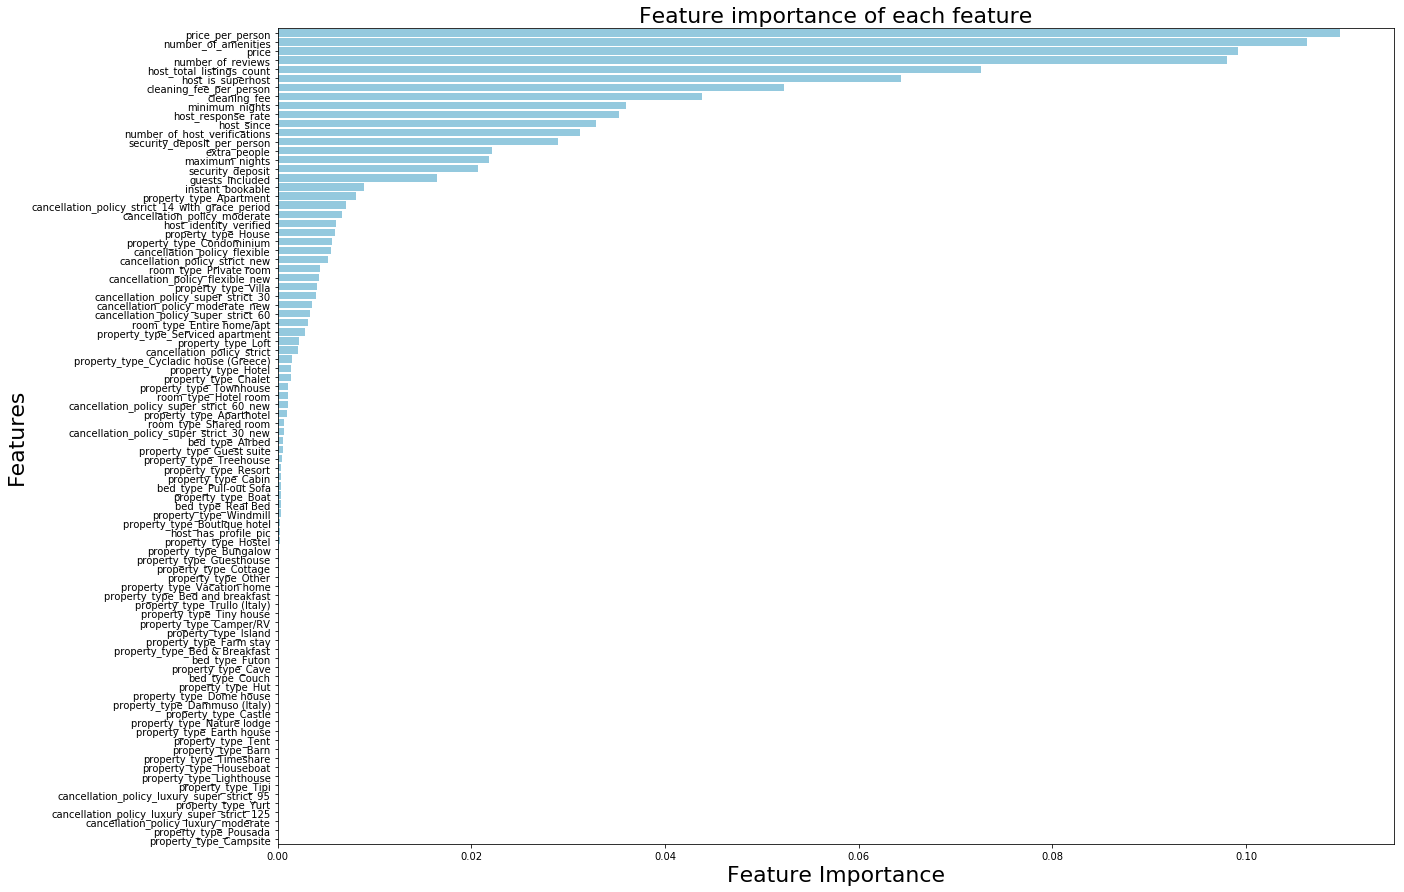

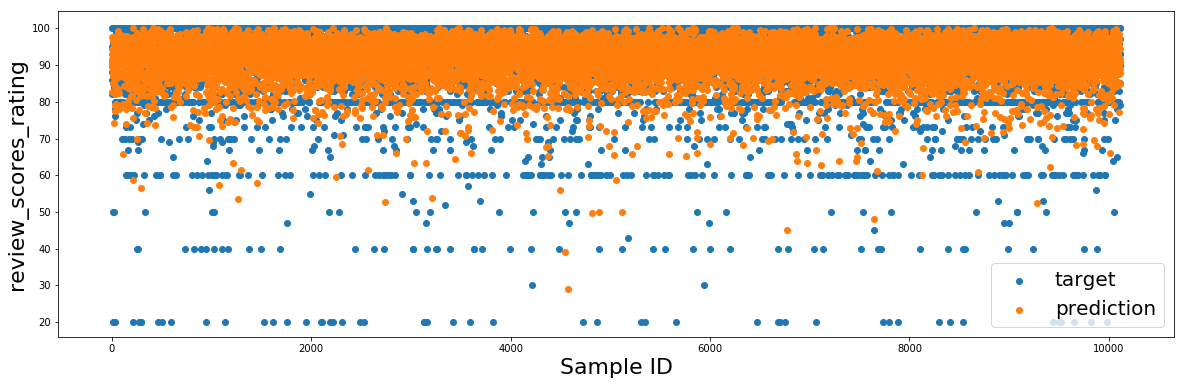

In [358]:
# TRY SINGLE LABEL RANDOMFOREST
importlib.reload(feature_tools)

ff = feature_tools.FeaturesTools(df = features_international[features_international.columns.difference(rating_features[1:])],
                                 label_name = rating_features[0], random_seed = random_seed)
#imp1, rf = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = True)
# df_importance, df_err, rf, cv_rsults, best_params_ = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = True)
df_importance, df_err, rf = ff.randomForestAnalysis(plotResults = [True, False, True, False], tuneModelParameters = False)

Interestingly, we observe that some of the most important features have changed. Moreover, the top 4 features for the international hosts have a similar importance. From the previous analyses we found that even among the top 4 features there was a significant importance difference (not all in the similar importance range)

# Create interactive network graph showing for each international host the cities in which is present

In [ ]:
import os
import json
import flask
import itertools
import pandas as pd
import networkx as nx
from networkx.readwrite import json_graph

In [359]:
# get all the listings_detailed.cvs files in the data_location folder

data_location = '/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet'
all_files = os.listdir(data_location)
listings_detailed = [i for i in all_files if 'listings_detailed.csv' in i]

# open all listings_detailed.csv files iteratively. For each file keep:
# the city and the average latitude, longitude
# the host ids
# the host names
# the host number of listings in a city
# those info are stored in df_world

df_world = pd.DataFrame()

idx_advancment = 0
for file in listings_detailed:
    idx_advancment += 1
    city_name = file.split('_')[1]
    print('> Analyzing city ' + str(int(idx_advancment)) + '/' + str(int(len(listings_detailed))) + ' : ' + city_name + '..................', end = '\r')
    tmp = pd.read_csv(data_location + '/' + file, low_memory = False)
    city_latitude = tmp.latitude.mean()
    city_longitude = tmp.longitude.mean()
    tmp['number_listings_by_host'] = tmp.groupby('host_id')['host_id'].transform('size')
    tmp = tmp.sort_values(by = 'number_listings_by_host', ascending = False)
    tmp = tmp.groupby(['host_id', 'host_name']).size().sort_values(ascending = False).to_frame().reset_index()
    tmp.columns = ['host_id', 'host_name', 'nb_listings_city']
    tmp['city'] = city_name
    tmp['city_avg_latitude'] = city_latitude
    tmp['city_avg_longitude'] = city_longitude
    
    df_world = pd.concat([df_world, tmp])
    

In [385]:
nb_cities_min = 10

df_multiple = df_world.copy()
df_multiple['host_nb_city_presence'] = df_multiple.groupby(['host_id', 'host_name'])['city'].transform('size')
df_multiple['nb_listings_world'] = df_multiple.groupby(['host_id', 'host_name'])['nb_listings_city'].transform('sum')
df_multiple = df_multiple[df_multiple['host_nb_city_presence'] >= nb_cities_min].sort_values(by = 'host_nb_city_presence', ascending = False)
df_multiple = df_multiple.groupby(['host_id', 'host_name']).aggregate(lambda x: x.unique().tolist())
display(df_multiple.head(2))



,,nb_listings_city,city,city_avg_latitude,city_avg_longitude,host_nb_city_presence,nb_listings_world
host_id,host_name,,,,,,
4962900,Stay Alfred,"[4, 205, 32, 18, 38, 11, 92, 5, 84, 16, 82]","[San Diego, Nashville, Columbus, Denver, Twin ...","[32.76811059307942, 36.161406516454356, 39.989...","[-117.18003625793321, -86.76845030486153, -82....",[12],[619]
12243051,Sonder,"[96, 165, 240, 8, 158, 28, 71, 13, 75, 186]","[New York City, Montreal, Boston, San Francisc...","[40.72881837526117, 45.51608418052235, 42.3385...","[-73.95126443805917, -73.5893906034262, -71.08...",[10],[1040]


In [386]:
edges = pd.DataFrame()

for index, row in df_multiple.iterrows():
    tmp0 = row['city']
    tmp1 = row['city'][1:] + [row['city'][0]]
    
    connections = pd.DataFrame({'source':row['city'], 'target':row['city'][1:] + [row['city'][0]]})
    
    edges = pd.concat([edges, connections])


    
edges = edges.reset_index(drop = True).drop_duplicates()
print(edges.shape)
edges.head()

(129, 2)


,source,target
0,San Diego,Nashville
1,Nashville,Columbus
2,Columbus,Denver
3,Denver,Twin Cities MSA
4,Twin Cities MSA,"Washington, D.C."


In [388]:
G = nx.DiGraph()

for index, row in edges.iterrows():
    G.add_edge(row.source, row.target)

for n in G:
    G.node[n]['name'] = n

# write json formatted data
d = json_graph.node_link_data(G)  # node-link format to serialize
# write json
json.dump(d, open('force/force.json', 'w'))
print('Wrote node-link JSON data to force/force.json')

# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder='force')


@app.route('/')
def static_proxy():
    return app.send_static_file('force.html')


print('\nGo to http://localhost:8000 to see the example\n')
app.run(port=8000)

Wrote node-link JSON data to force/force.json

Go to http://localhost:8000 to see the example

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)
